In [1]:
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import sacrebleu
from evaluate import load
from bert_score import score
from nltk.translate.meteor_score import meteor_score

d:\Academic Work\Multihop_Project\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import stanza
stanza.download("ur")
nlp = stanza.Pipeline("ur")

def urdu_tokenizer(text):
    doc = nlp(text)
    return [word.text for sent in doc.sentences for word in sent.words]


2025-05-25 23:35:00 INFO: Downloaded file to C:\Users\hamma\stanza_resources\resources.json
2025-05-25 23:35:00 INFO: Downloading default packages for language: ur (Urdu) ...
2025-05-25 23:35:01 INFO: File exists: C:\Users\hamma\stanza_resources\ur\default.zip
2025-05-25 23:35:02 INFO: Finished downloading models and saved to C:\Users\hamma\stanza_resources
2025-05-25 23:35:02 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2025-05-25 23:35:02 INFO: Downloaded file to C:\Users\hamma\stanza_resources\resources.json
2025-05-25 23:35:02 INFO: Loading these models for language: ur (Urdu):
| Processor | Package       |
-----------------------------
| tokenize  | udtb          |
| pos       | udtb_nocharlm |
| lemma     | udtb_nocharlm |
| depparse  | udtb_nocharlm |

2025-05-25 23:35:03 INFO: Using device: cuda
2025-05-25 23:35:03 INFO: Loading: t

In [3]:
rouge = load("rouge")

In [4]:
# --- Load Your CSVs --
vanilla_df = pd.read_csv("../../../Dataset_code_csvs/hotpotQA/hotpotQA_dataset_versions/5884paras_598queries/Urdu/598_QnAs_translated.csv")
simple_rag_df=pd.read_csv("../../results/pipeline results/5884paras_598qna/copies/simple_rag_qna_results_GPU_version - Copy.csv")
lqr_df = pd.read_csv("../../results/pipeline results/5884paras_598qna/copies/LQR_processed_results - Copy.csv")
mod_lqr_df = pd.read_csv("../../results/pipeline results/5884paras_598qna/copies/modLQR_processed_results - Copy.csv")

# --- Ground Truth ---
references = vanilla_df['translated_answer'].astype(str).tolist()

# --- Predictions ---
vanilla_preds = simple_rag_df['final_answer'].astype(str).tolist()
lqr_preds = lqr_df['final_answer'].astype(str).tolist()
mod_lqr_preds = mod_lqr_df['final_answer'].astype(str).tolist()

In [5]:
# --- Define Metric Functions ---
def calculate_nltk_bleu(references, hypotheses):
    scores = []
    smooth = SmoothingFunction().method1
    for ref, hyp in zip(references, hypotheses):
        score = sentence_bleu([ref.split()], hyp.split(), smoothing_function=smooth)
        scores.append(score * 100)
    return scores

def calculate_sacrebleu(references, hypotheses):
    return [sacrebleu.sentence_bleu(hyp, [ref]).score for ref, hyp in zip(references, hypotheses)]

def calculate_rouge(references, hypotheses):
    results = rouge.compute(
        predictions=hypotheses,
        references=references,
        tokenizer=lambda x: x.split(),
        use_aggregator=False
    )
    return results['rouge1'], results['rouge2'], results['rougeL']

def calculate_meteor(references, hypotheses, urdu_tokenizer):
    tokenized_references = [urdu_tokenizer(ref) for ref in references]
    tokenized_hypotheses = [urdu_tokenizer(hyp) for hyp in hypotheses]
    return [meteor_score([ref], hyp) for ref, hyp in zip(tokenized_references, tokenized_hypotheses)]

def calculate_bert_score(references, hypotheses):
    P, R, F1 = score(hypotheses, references, lang="ur", model_type="xlm-roberta-large")
    return P.tolist(), R.tolist(), F1.tolist()

def calculate_exact_match(references, hypotheses):
    return [1 if ref.strip() == hyp.strip() else 0 for ref, hyp in zip(references, hypotheses)]


In [6]:
def evaluate_pipeline(name, references, predictions):
    print(f"\n🚀 Evaluating pipeline: {name}")

    nltk_bleu = calculate_nltk_bleu(references, predictions)
    sacrebleu_scores = calculate_sacrebleu(references, predictions)
    rouge1, rouge2, rougeL = calculate_rouge(references, predictions)
    meteor = calculate_meteor(references, predictions, urdu_tokenizer)
    exact_match = calculate_exact_match(references, predictions)
    bert_p, bert_r, bert_f1 = calculate_bert_score(references, predictions)

    print(f"✅ All scores calculated for: {name}")

    return pd.DataFrame({
        'translated_question': vanilla_df['translated_question'],  # Aligning with each row
        f'{name}_nltk_bleu': nltk_bleu,
        f'{name}_sacrebleu': sacrebleu_scores,
        f'{name}_rouge1': rouge1,
        f'{name}_rouge2': rouge2,
        f'{name}_rougeL': rougeL,
        f'{name}_meteor': meteor,
        f'{name}_exact_match': exact_match,
        f'{name}_bert_precision': bert_p,
        f'{name}_bert_recall': bert_r,
        f'{name}_bert_f1': bert_f1
    })


In [7]:
vanilla_scores = evaluate_pipeline("Vanilla_RAG", references, vanilla_preds)
lqr_scores = evaluate_pipeline("LQR_RAG", references, lqr_preds)
mod_lqr_scores = evaluate_pipeline("modLQR_RAG", references, mod_lqr_preds)



🚀 Evaluating pipeline: Vanilla_RAG
✅ All scores calculated for: Vanilla_RAG

🚀 Evaluating pipeline: LQR_RAG
✅ All scores calculated for: LQR_RAG

🚀 Evaluating pipeline: modLQR_RAG
✅ All scores calculated for: modLQR_RAG


In [10]:
import pandas as pd
from scipy import stats

# Slice to exclude first 98 records (keep 99-end)
vanilla_subset = vanilla_scores.iloc[98:]
lqr_subset = lqr_scores.iloc[98:]
mod_lqr_subset = mod_lqr_scores.iloc[98:]

# List of all metrics
metrics = [
    'nltk_bleu', 'sacrebleu', 'rouge1', 'rouge2', 'rougeL',
    'meteor', 'exact_match', 'bert_precision', 'bert_recall', 'bert_f1'
]

# Create summary DataFrame
results = pd.DataFrame(index=metrics, columns=['Vanilla', 'LQR', 'modLQR'])

# Calculate means for each pipeline (excluding first 98)
for metric in metrics:
    results.loc[metric, 'Vanilla'] = vanilla_subset[f'Vanilla_RAG_{metric}'].mean()
    results.loc[metric, 'LQR'] = lqr_subset[f'LQR_RAG_{metric}'].mean()
    results.loc[metric, 'modLQR'] = mod_lqr_subset[f'modLQR_RAG_{metric}'].mean()

# Statistical testing on the subset
p_values = []
for metric in metrics:
    _, p_val = stats.ttest_rel(
        lqr_subset[f'LQR_RAG_{metric}'],
        mod_lqr_subset[f'modLQR_RAG_{metric}']
    )
    p_values.append(f"{p_val:.4f}{'*' if p_val < 0.05 else ''}")

results['LQR_vs_modLQR_p'] = p_values

# # Format and display
# pd.set_option('display.float_format', lambda x: f"{x:.4f}")
# print("\n📊 Mean Scores (Records 99-598 Only):")
# print(results)
# print(f"\nAnalyzing {len(vanilla_subset)} records (99-598)")

results.columns = ['Simple RAG', 'LR-RAG', 'DQ-RAG', 'LR_vs_DQ_p']

# Format and display
pd.set_option('display.float_format', lambda x: f"{x:.4f}")
print("\n📊 Mean Scores (Records 99-598 Only):")
print(results)
print(f"\nAnalyzing {len(vanilla_subset)} records (99-598)")


📊 Mean Scores (Records 99-598 Only):
               Simple RAG LR-RAG DQ-RAG LR_vs_DQ_p
nltk_bleu          0.5643 0.6517 0.4697     0.1502
sacrebleu          1.3641 1.7370 1.0853     0.1182
rouge1             0.0346 0.0335 0.0300     0.5107
rouge2             0.0067 0.0065 0.0051     0.6356
rougeL             0.0334 0.0334 0.0294     0.4506
meteor             0.0445 0.0455 0.0474     0.7309
exact_match        0.0040 0.0040 0.0020     0.5642
bert_precision     0.7994 0.8028 0.7898    0.0000*
bert_recall        0.8415 0.8417 0.8413     0.7694
bert_f1            0.8194 0.8212 0.8143    0.0000*

Analyzing 500 records (99-598)


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Slice to exclude first 98 records (keep 99-end)
vanilla_subset = vanilla_scores.iloc[98:]
lqr_subset = lqr_scores.iloc[98:]
mod_lqr_subset = mod_lqr_scores.iloc[98:]

# List of all metrics
metrics = [
    'nltk_bleu', 'sacrebleu', 'rouge1', 'rouge2', 'rougeL',
    'meteor', 'exact_match', 'bert_precision', 'bert_recall', 'bert_f1'
]

# Create summary DataFrame
results = pd.DataFrame(index=metrics, columns=['Vanilla', 'LQR', 'modLQR'])

# Calculate means for each pipeline (excluding first 98)
for metric in metrics:
    results.loc[metric, 'Vanilla'] = vanilla_subset[f'Vanilla_RAG_{metric}'].mean()
    results.loc[metric, 'LQR'] = lqr_subset[f'LQR_RAG_{metric}'].mean()
    results.loc[metric, 'modLQR'] = mod_lqr_subset[f'modLQR_RAG_{metric}'].mean()

# Save to CSV
output_path = '../../results/scores_results/nlp_scores/5884paras_598qna/nlp_scores_gen.csv'
results.to_csv(output_path, index=True)
print(f"\n✅ Results saved to: {output_path}")



✅ Results saved to: ../../results/scores_results/nlp_scores/5884paras_598qna/nlp_scores_gen.csv


C:\Users\hamma\AppData\Local\Temp\ipykernel_3012\957131653.py:42: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
d:\Academic Work\Multihop_Project\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


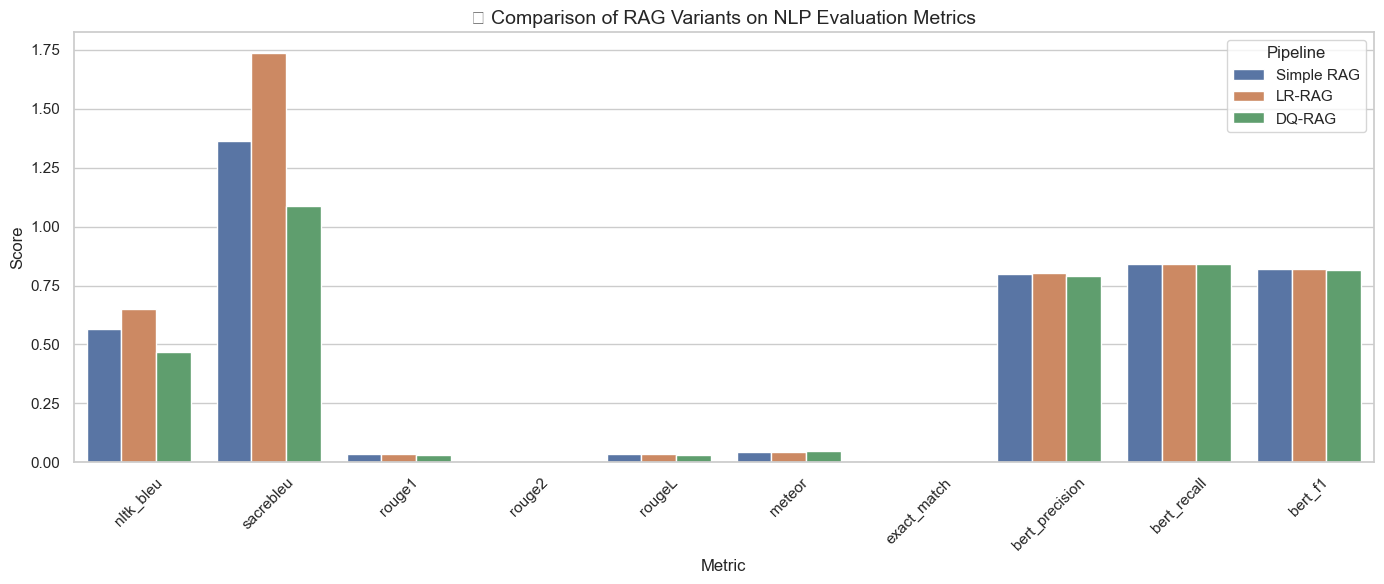

C:\Users\hamma\AppData\Local\Temp\ipykernel_3012\957131653.py:51: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
d:\Academic Work\Multihop_Project\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


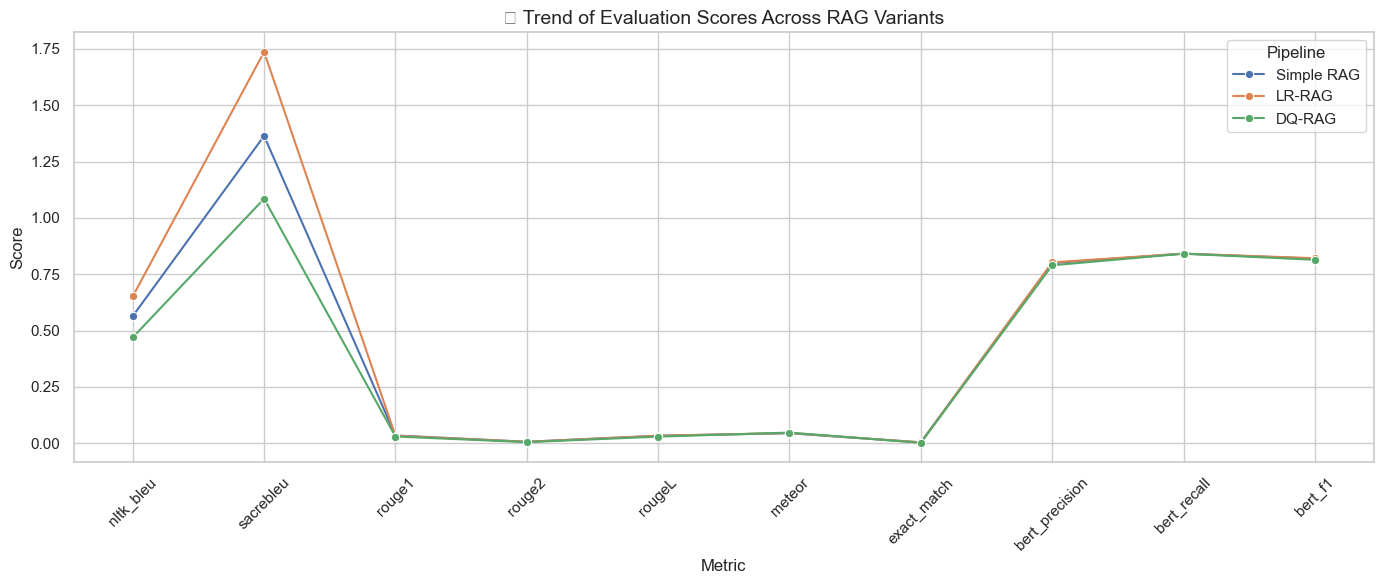

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Slice to exclude first 98 records
vanilla_subset = vanilla_scores.iloc[98:]
lqr_subset = lqr_scores.iloc[98:]
mod_lqr_subset = mod_lqr_scores.iloc[98:]

# List of all metrics
metrics = [
    'nltk_bleu', 'sacrebleu', 'rouge1', 'rouge2', 'rougeL',
    'meteor', 'exact_match', 'bert_precision', 'bert_recall', 'bert_f1'
]

# Create summary DataFrame
results = pd.DataFrame(index=metrics, columns=['Simple RAG', 'LR-RAG', 'DQ-RAG'])

# Fill in the means
for metric in metrics:
    results.loc[metric, 'Simple RAG'] = vanilla_subset[f'Vanilla_RAG_{metric}'].mean()
    results.loc[metric, 'LR-RAG'] = lqr_subset[f'LQR_RAG_{metric}'].mean()
    results.loc[metric, 'DQ-RAG'] = mod_lqr_subset[f'modLQR_RAG_{metric}'].mean()

# Convert to float (ensures clean plotting)
results = results.astype(float)

# Reset index for plotting
results_reset = results.reset_index().rename(columns={'index': 'Metric'})

# Melt the DataFrame for Seaborn
df_melted = results_reset.melt(id_vars='Metric', var_name='Pipeline', value_name='Score')

# Set plot style
sns.set(style="whitegrid")

# Create grouped bar plot
plt.figure(figsize=(14, 6))
sns.barplot(data=df_melted, x='Metric', y='Score', hue='Pipeline')
plt.title('📊 Comparison of RAG Variants on NLP Evaluation Metrics', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='Pipeline')
plt.show()

# Optional: Line plot (for trend visualization)
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_melted, x='Metric', y='Score', hue='Pipeline', marker='o')
plt.title('📈 Trend of Evaluation Scores Across RAG Variants', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='Pipeline')
plt.show()


C:\Users\hamma\AppData\Local\Temp\ipykernel_3012\3990978966.py:39: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) Arial.
  plt.tight_layout()
d:\Academic Work\Multihop_Project\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


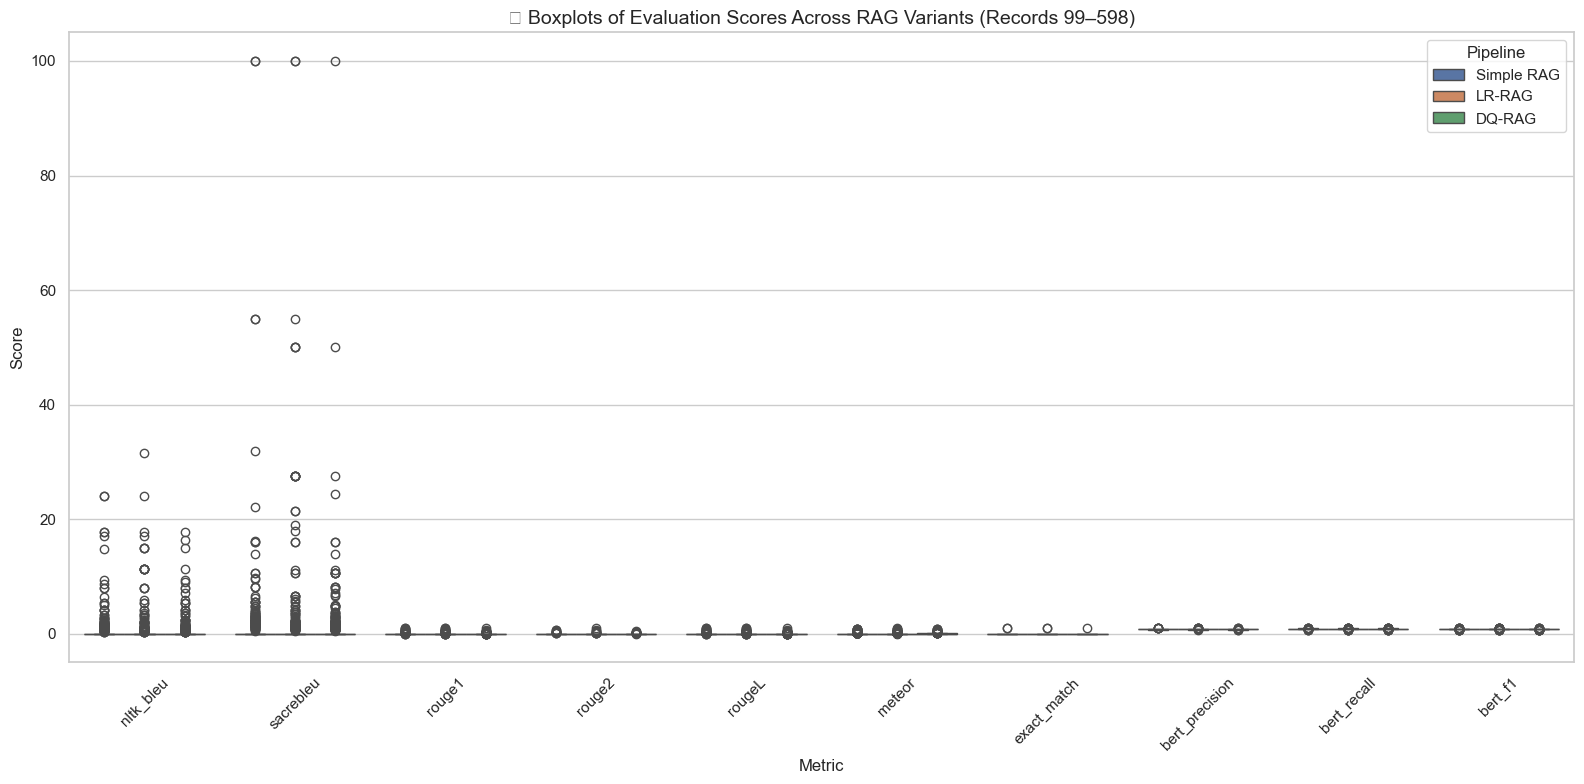

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure seaborn style is applied
sns.set(style="whitegrid")

# List of metrics
metrics = [
    'nltk_bleu', 'sacrebleu', 'rouge1', 'rouge2', 'rougeL',
    'meteor', 'exact_match', 'bert_precision', 'bert_recall', 'bert_f1'
]

# Collect data for boxplot in long format
boxplot_data = []

for metric in metrics:
    boxplot_data.extend([
        {'Metric': metric, 'Pipeline': 'Simple RAG', 'Score': score}
        for score in vanilla_subset[f'Vanilla_RAG_{metric}']
    ])
    boxplot_data.extend([
        {'Metric': metric, 'Pipeline': 'LR-RAG', 'Score': score}
        for score in lqr_subset[f'LQR_RAG_{metric}']
    ])
    boxplot_data.extend([
        {'Metric': metric, 'Pipeline': 'DQ-RAG', 'Score': score}
        for score in mod_lqr_subset[f'modLQR_RAG_{metric}']
    ])

# Create DataFrame for plotting
df_box = pd.DataFrame(boxplot_data)

# Plot boxplots grouped by metric
plt.figure(figsize=(16, 8))
sns.boxplot(data=df_box, x='Metric', y='Score', hue='Pipeline')
plt.title("📦 Boxplots of Evaluation Scores Across RAG Variants (Records 99–598)", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='Pipeline')
plt.show()


✅ Visualization saved as metric_comparison.png
✅ Score distributions saved as score_distributions.png


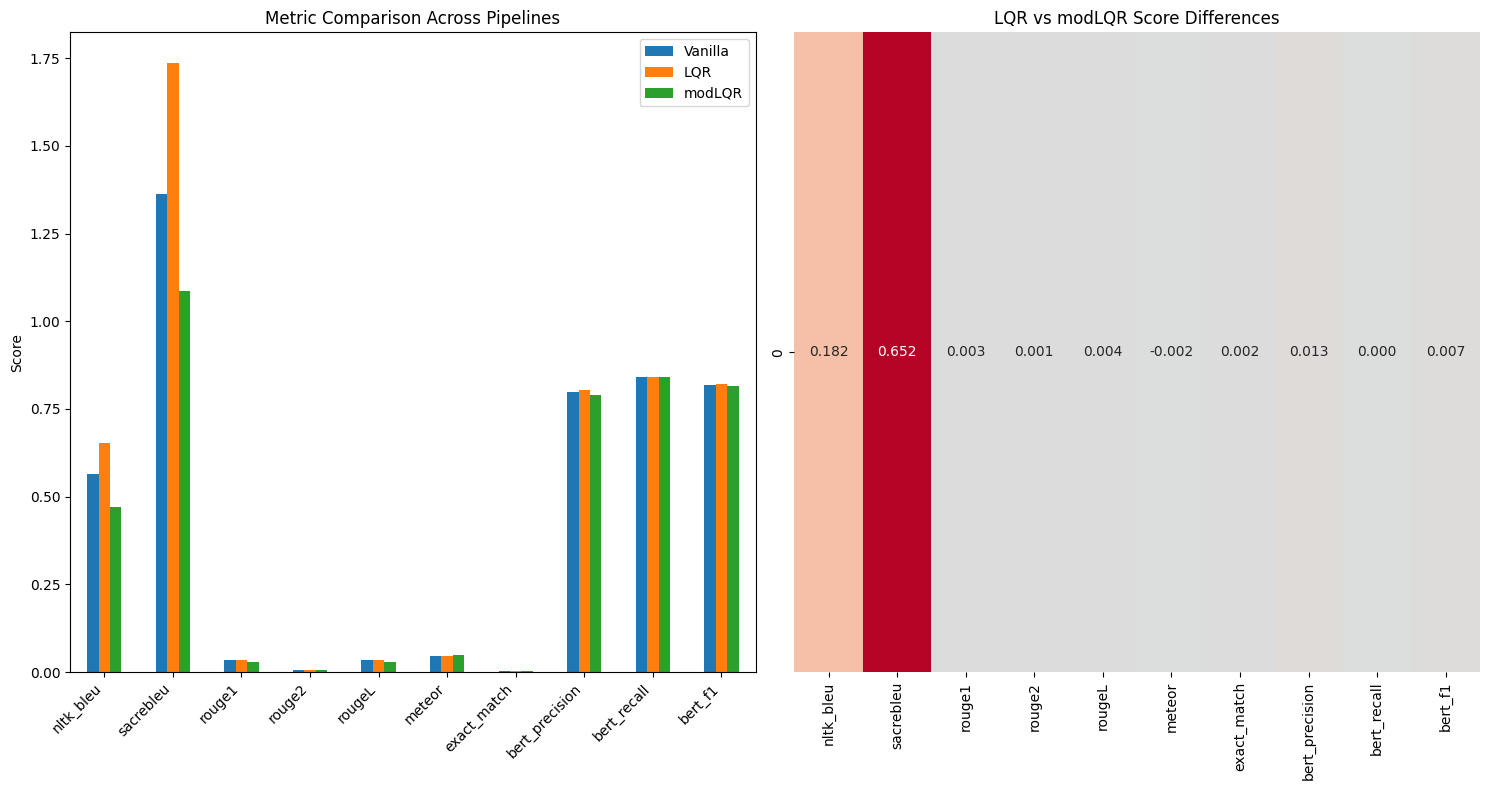

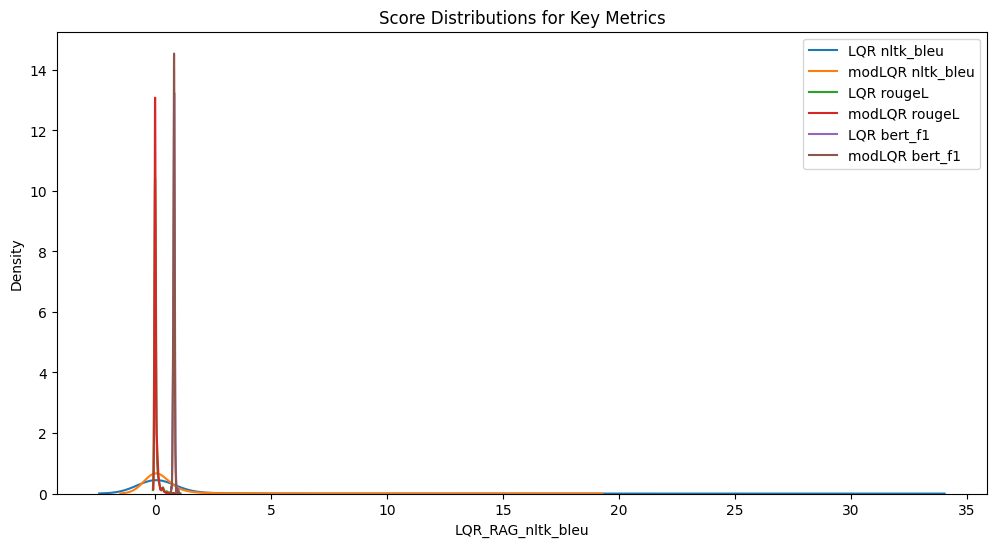

In [36]:

plt.figure(figsize=(15, 8))

# 1. Bar plot comparing all metrics
plt.subplot(1, 2, 1)
results[['Vanilla', 'LQR', 'modLQR']].plot(kind='bar', ax=plt.gca())
plt.title('Metric Comparison Across Pipelines')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# 2. Heatmap of score differences (LQR - modLQR)
plt.subplot(1, 2, 2)
diff = results['LQR'] - results['modLQR']
# Ensure numeric values for heatmap
diff_numeric = diff.astype(float).to_frame().T
sns.heatmap(diff_numeric, annot=True, cmap='coolwarm', 
            center=0, fmt=".3f", cbar=False)
plt.title('LQR vs modLQR Score Differences')
plt.tight_layout()

plt.savefig('../../results/scores_results/nlp_scores/5884paras_598qna/metric_comparison.png')
print("✅ Visualization saved as metric_comparison.png")

# 3. Score distribution plots (for key metrics)
key_metrics = ['nltk_bleu', 'rougeL', 'bert_f1']
plt.figure(figsize=(12, 6))
for metric in key_metrics:
    sns.kdeplot(lqr_subset[f'LQR_RAG_{metric}'].astype(float), label=f'LQR {metric}')
    sns.kdeplot(mod_lqr_subset[f'modLQR_RAG_{metric}'].astype(float), label=f'modLQR {metric}')
plt.title('Score Distributions for Key Metrics')
plt.legend()
plt.savefig('../../results/scores_results/nlp_scores/5884paras_598qna/score_distributions.png')
print("✅ Score distributions saved as score_distributions.png")
